# Preprocessing MedMNIST dataset

This is a preprocessing notebook for the MedMNIST dataset to use to create images form the csv files (https://medmnist.com/)

The downloading steps of the script is based on the github instructions pages

https://github.com/MedMNIST/MedMNIST?tab=readme-ov-file
https://github.com/MedMNIST/MedMNIST/blob/main/examples/getting_started_without_PyTorch.ipynb


It is based on the preprocessing guide in this kaggle notebook:  
https://www.kaggle.com/code/vesuvius13/how-to-preprocess-and-train-a-cnn-step-by-step

In [ ]:
import os
import numpy as np
from medmnist import INFO, Evaluator
import medmnist
import dataset_without_pytorch
from dataset_without_pytorch import get_loader

# Loading dataset of image size 28x28x28

In [ ]:
## Loading dataset of image size 28x28x28

data_flag = 'fracturemnist3d'
download = True
NUM_EPOCHS = 3
BATCH_SIZE = 128
lr = 0.001

info = INFO[data_flag]
DataClass = getattr(dataset_without_pytorch, info['python_class'])

# load the data
train_dataset = DataClass(split='train',  download=download)

# encapsulate data into dataloader form
train_loader = get_loader(dataset=train_dataset, batch_size=BATCH_SIZE)

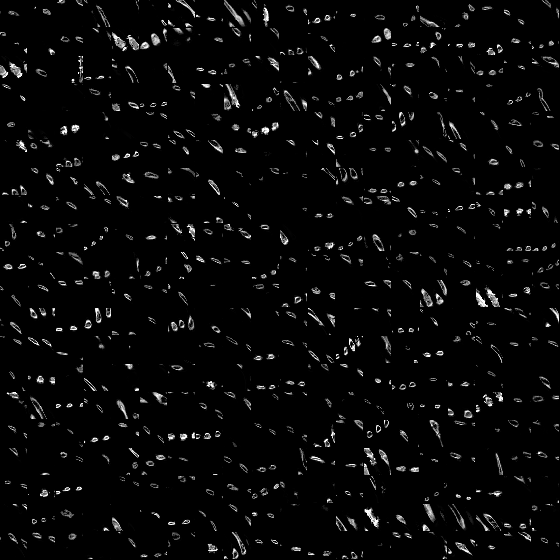

In [21]:
frames = train_dataset.montage(length=20, save_folder="tmp_without_pytorch/")

frames[10]

# Loading dataset of image size 64x64x64

In [ ]:
data_flag = 'fracturemnist3d'
download = True
NUM_EPOCHS = 3
BATCH_SIZE = 128
lr = 0.001
info = INFO[data_flag]
DataClass = getattr(dataset_without_pytorch, info['python_class'])

# load the data
train_dataset = DataClass(split='train',  download=download, size=64)
val_dataset = DataClass(split='val',  download=download, size=64)
test_dataset = DataClass(split='test',  download=download, size=64)

# encapsulate data into dataloader form
train_loader = get_loader(dataset=train_dataset, batch_size=BATCH_SIZE)

In [ ]:
# Script to make pseudo segmentations for the FractionMNIST dataset  
import SimpleITK as sitk
import matplotlib.pyplot as plt
from scipy.ndimage import binary_fill_holes, binary_dilation, binary_erosion

# label": {
#             "0": "buckle rib fracture",
#             "1": "nondisplaced rib fracture",
#             "2": "displaced rib fracture",
#         }

save_folder = './MedMNIST/FractureMNIST3D/NIFTI_dataset'
# name = 0
max_num = 0
for im_name in os.listdir(os.path.join(save_folder, 'images')):
    idx = im_name.find('.nii.gz')             # Works for LITS dataset. Needs to be adjusted per dataset
    idx2 = im_name.find('case')
    patient_id = im_name[idx2+4:idx]
    if int(patient_id)>max_num:
        max_num = int(patient_id)
print(max_num)
name = max_num+1
for i in range(len(train_dataset)):
    array, label =train_dataset[i]
    array = np.float32(np.array(array)[0])

    image = sitk.Cast(sitk.GetImageFromArray(array), sitk.sitkFloat64)

    annotation = (array>0).astype(np.int_)

    annotation_filled = binary_fill_holes(annotation).astype(int)


    annotation_alt = binary_dilation(annotation).astype(annotation.dtype)


    annotation_final = np.float32(binary_fill_holes(annotation_alt))
    print(type(annotation_final), type(annotation_final[0,0,0]))

    annotation_final_2 = np.float32(binary_erosion(annotation_final))
    print(type(annotation_final_2), type(annotation_final_2[0,0,0]))


    # plt.show()
    file_path = os.path.join(save_folder, 'raw_data','images',  f'{label[0]}_case{name}.nii.gz')
    sitk.WriteImage(image, file_path)

    ann_image = sitk.Cast(sitk.GetImageFromArray(annotation_final), sitk.sitkInt8)

    file_path_ann = os.path.join(save_folder, 'raw_data','labels', f'{label[0]}_case{name}_mask.nii.gz')
    sitk.WriteImage(ann_image, file_path_ann)
    name +=1
   